# Korelace časových řad
Tento notebook popisuje vývoj volby metod pro zjišťování korelace časových řad.

## Načtení dat
Použijeme data z World Bank.

In [1]:
import pandas as pd
import world_bank_data as wb
import datetime

dataset_props = {
    'SP.DYN.TFRT.IN': {
        'id': 'tfr',
        'name': 'Total fertility rate',
        'description': 'Počet dětí, které by žena mohla mít, kdyby po celý její život platily hodnoty plodnosti podle věku pro daný rok.',
        'unit': 'počet dětí'
    },
    'EN.ATM.CO2E.KT': {
        'id': 'co2_emissions',
        'name': 'Emise CO2',
        'description': 'Emise CO2 vzniklé spalování fosilních paliv a výrobou cementu.',
        'unit': 'kt'
    },
    'NY.GDP.PCAP.PP.CD': {
        'id': 'gdp',
        'name': 'HDP per capita',
        'description': 'HDP per capita v mezinárodních dolarech podle parity kupní síly',
        'unit': 'mezinárodní dolary'
    },
    'SL.TLF.CACT.FE.ZS': {
        'id': 'lfp_female',
        'name': 'Participace žen 15+ v pracovním procesu',
        'description': 'Podíl ekonomicky aktivních žen ve věku 15 a více let (odhad ILOSTAT)',
        'unit': '%'
    },
    'SH.STA.SUIC.P5': {
        'id': 'suicide_mortality_rate',
        'name': 'Sebevražednost',
        'description': 'Hrubý počet sebevražd na 100000 obyvatel (WHO)',
        'unit': 'počet sebevražd'
    }
}

regions = [
    'WLD', # World
    'EUU', # European Union
    'CZE',
    'DEU',
    'GRC',
    'ITA',
    'POL',
    'GBR'
]

datasets = {}
for dataset_id in dataset_props:
    # Collect data since 1980 until now
    year = datetime.date.today().strftime("%Y")
    series = wb.get_series(dataset_id, date='1980:%s' % year, id_or_value='id', simplify_index=True)

    # Process dataset for each selected region
    per_region = {}

    for region in regions:
        data = series[region]

        # Strip NaNs
        index = data.index
        start = 0
        while start <= len(index) - 1:
            if not pd.isnull(data[index[start]]):
                break
            start = start + 1
        end = len(index) - 1
        while end >= 0:
            if not pd.isnull(data[index[end]]):
                break
            end = end - 1
        data = data.iloc[start:(end + 1)] # Last index is exclusive

        # Compute intermediary missing values using interpolation
        data = data.interpolate()

        if data.size < 3:
            print('Skipping %s for %s' % (dataset_id, region))
        else:
            per_region[region] = {
                'data': data
            }

    datasets[dataset_id] = per_region

tfr = datasets.pop('SP.DYN.TFRT.IN')

Skipping EN.ATM.CO2E.KT for WLD
Skipping EN.ATM.CO2E.KT for EUU


## Statistiky

## Základní vlastnosti

In [2]:
for dataset_id in datasets:
    for region in datasets[dataset_id]:
        data = datasets[dataset_id][region]['data']
        datasets[dataset_id][region]['properties'] = data.describe()

## Pohled na vývoj TFR
Celosvětový vývoj (WLD) je narozdíl od ostatních grafů škálovaný jinak.

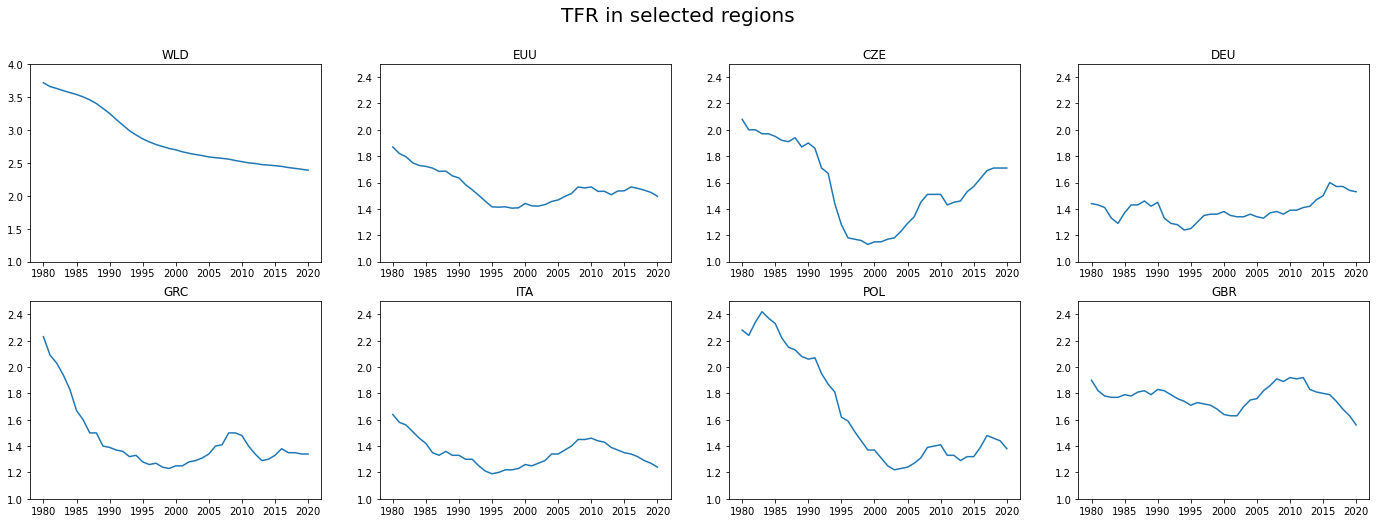

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figwidth(24)
fig.set_figheight(8)
fig.suptitle('TFR in selected regions', fontsize=20)

def plot(i, ylim):
    plt.subplot(2, 4, i + 1)
    plt.plot(tfr[regions[i]]['data'])
    plt.xticks(tfr[regions[i]]['data'].index[0::5])
    plt.title(regions[i])
    plt.ylim(1.0, ylim)

plot(0, 4.0) # Plot WLD separately with a differently scaled y-axis

for i in range(1, len(regions)):
    plot(i, 2.5)

## Augmented Dickey Fuller Test
Otestujeme stacionaritu dat.
Další možností posouzení stacionarity je pohled na graf parciálních autokorelací popsaný v notebooku `prediction` nebo jiný test jako KPSS.

In [4]:
from statsmodels.tsa.stattools import adfuller

def process_adfuller(region, alpha=0.05):
    result = adfuller(region['data'], autolag='AIC')
    region['stationarity'] = {
        'adfuller': {
            'stationary': True if result[1] < alpha else False,
            'statistic': result[0],
            'pvalue': result[1],
            'alpha': alpha,
            'lag': result[2],
            'nobs': result[3],
            'autolag': 'AIC'
        }
    }

print('TFR')
for region in tfr:
    process_adfuller(tfr[region])
    print('  ' + region + ': ' + ('stationary' if tfr[region]['stationarity']['adfuller']['stationary'] else 'non-stationary'))

for dataset_id in datasets:
    print(dataset_id)
    for region_id in datasets[dataset_id]:
        process_adfuller(datasets[dataset_id][region_id])
        print('  ' + region_id + ': ' + ('stationary' if datasets[dataset_id][region_id]['stationarity']['adfuller']['stationary'] else 'non-stationary'))


TFR
  WLD: stationary
  EUU: stationary
  CZE: non-stationary
  DEU: non-stationary
  GRC: stationary
  ITA: stationary
  POL: non-stationary
  GBR: non-stationary
EN.ATM.CO2E.KT
  CZE: non-stationary
  DEU: non-stationary
  GRC: non-stationary
  ITA: non-stationary
  POL: non-stationary
  GBR: non-stationary
NY.GDP.PCAP.PP.CD
  WLD: non-stationary
  EUU: non-stationary
  CZE: non-stationary
  DEU: non-stationary
  GRC: non-stationary
  ITA: non-stationary
  POL: non-stationary
  GBR: non-stationary
SL.TLF.CACT.FE.ZS
  WLD: non-stationary
  EUU: stationary
  CZE: non-stationary
  DEU: non-stationary
  GRC: non-stationary
  ITA: non-stationary
  POL: non-stationary
  GBR: non-stationary
SH.STA.SUIC.P5
  WLD: non-stationary
  EUU: non-stationary
  CZE: non-stationary
  DEU: non-stationary
  GRC: stationary
  ITA: stationary
  POL: non-stationary
  GBR: non-stationary


## Korelace dvou stacionárních časových řad
- Pearsonův korelační koeficient
- Lineární regrese s t-testem, jehož nulová hypotéza je, že sklon regresní přímky je nulový.
- Vyzkoušení této techniky na několika relativních zpožděních (lag) obou časových řad.

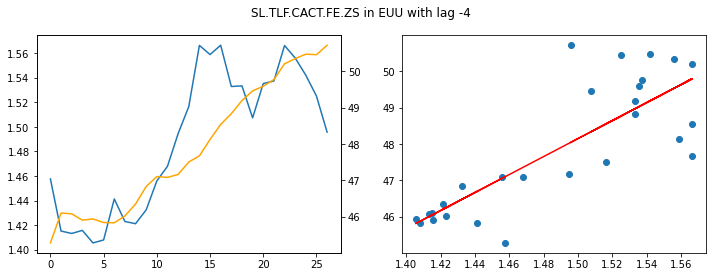

{'correlation': True, 'linear_regression': {'slope': 24.757486403713013, 'intercept': 11.012585112654016, 'p_value': 3.8672415629278345e-07, 'std_err': 3.634756857419172}, 'pearson_product_moment_correlation': {'r_value': 0.8061208387953724}, 'lag': -4}


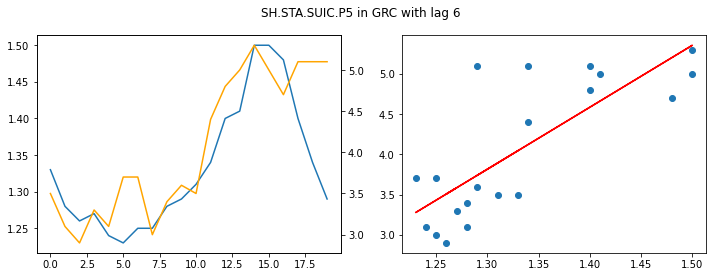

{'correlation': True, 'linear_regression': {'slope': 7.689780390800622, 'intercept': -6.181632370741829, 'p_value': 4.96445751804275e-05, 'std_err': 1.453301711587061}, 'pearson_product_moment_correlation': {'r_value': 0.7801748310736982}, 'lag': 6}


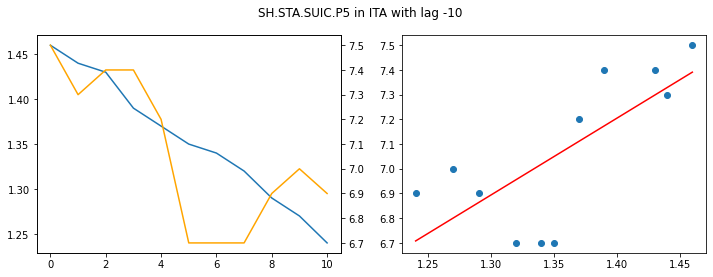

{'correlation': True, 'linear_regression': {'slope': 3.104909925821264, 'intercept': 2.857894736842108, 'p_value': 0.011681184283671243, 'std_err': 0.9847505139822483}, 'pearson_product_moment_correlation': {'r_value': 0.7244647659315976}, 'lag': -10}


In [5]:
from sklearn.linear_model import LinearRegression # For plotting
from scipy import stats # For the correlation and slope test
import numpy as np

def lag_interval(lagging: tuple, static: tuple, lag: int): 
    """Compute bounds when given intervals are lagged
    
    Parameters:
    - lagging: interval to be lagged
    - static: interval to relate the lag to
    - lag: relative lag, positive value points to the past
    
    Returns:
    - new_lagging: new bounds of the lagged interval or None if invalid
    - new_static: new bounds of the lagged interval or None if invalid
    - length: length of the both intervals of None if interval(s) invalid
    """

    # Compute start points
    lagging_start = lagging[0]
    static_start = lagging_start + lag

    if static_start < static[0]:
        lagging_start += static[0] - static_start
        static_start = static[0]
    
    # Compute end points
    static_end = static[1]
    lagging_end = static_end - lag

    if lagging_end > lagging[1]:
        static_end -= lagging_end - lagging[1]
        lagging_end = lagging[1]
    
    # Validate results
    if static_start > static_end or lagging_start > lagging_end:
        return None, None, None
    
    new_lagging = (lagging_start, lagging_end)
    new_static = (static_start, static_end)
    length = lagging_end - lagging_start

    return new_lagging, new_static, length

def plot_linear_regression(dataset_id, region_id, X, y, lag):
    model = LinearRegression()
    X_2d_array = np.asarray(X).reshape(-1, 1)
    model.fit(X_2d_array, y)
    pred = model.predict(X_2d_array)

    fig = plt.figure()
    fig.set_figwidth(12)
    fig.set_figheight(4)
    fig.suptitle(dataset_id + ' in ' + region_id + ' with lag ' + str(lag))
    plt.subplot(1, 2, 1)
    plt.plot(X.values)
    ax2 = plt.twinx()
    ax2.plot(y.values, color='orange')
    plt.autoscale()
    plt.subplot(1, 2, 2)
    plt.plot(X, pred, color='r')
    plt.scatter(X, y)
    plt.show()

def linear_regression(dataset_id, region_id, X, y, output=False):
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

    return {
        'correlation': True if p_value <= 0.05 else False,
        'linear_regression': {
            'slope': slope,
            'intercept': intercept,
            'p_value': p_value,
            'std_err': std_err
        },
        'pearson_product_moment_correlation': {
            'r_value': r_value
        }
    }

def linear_regression_lagged(dataset_id, region_id, X, y, maxlags=5, output='none'):
    """maxlags: lag series relatively between -maxlags and maxlags"""
    
    min_data_lenght = 5

    X_interval = (int(X.index[0]), int(X.index[-1]))
    X_length = X_interval[1] - X_interval[0]

    y_interval = (int(y.index[0]),
        int(y.index[-1]))
    y_length = y_interval[1] - y_interval[0]

    min_length = int(max(min_data_lenght, min(X_length, y_length) / 2))

    relations = {}

    for lag in range(-maxlags, maxlags):
        X_lagged, y_lagged, length = lag_interval(X_interval, y_interval, lag)

        if length != None and length >= min_length:
            primary = X
            other = y

            primary.index = primary.index.astype(int)
            other.index = other.index.astype(int)
            primary = primary.loc[(primary.index >= X_lagged[0]) & (primary.index <= X_lagged[1])]
            other = other.loc[(other.index >= y_lagged[0]) & (other.index <= y_lagged[1])]

            relations[lag] = linear_regression(dataset_id, region_id, primary, other, output=output)
    
    min_p_value = 2
    min_p_value_lag = None
    for lag in relations:
        cur_p_value = abs(relations[lag]['linear_regression']['p_value'])
        if cur_p_value < min_p_value:
            min_p_value = cur_p_value
            min_p_value_lag = lag
    datasets[dataset_id][region_id]['relation'] = relations[min_p_value_lag]
    datasets[dataset_id][region_id]['relation']['lag'] = min_p_value_lag
    
    if output == 'always' or (output == 'corr' and relations[min_p_value_lag]['correlation']):
        X_lagged, y_lagged, length = lag_interval(X_interval, y_interval, min_p_value_lag)
        primary = X
        other = y
        primary.index = primary.index.astype(int)
        other.index = other.index.astype(int)
        primary = primary.loc[(primary.index >= X_lagged[0]) & (primary.index <= X_lagged[1])]
        other = other.loc[(other.index >= y_lagged[0]) & (other.index <= y_lagged[1])]
        plot_linear_regression(dataset_id, region_id, primary, other, min_p_value_lag)
        print(datasets[dataset_id][region_id]['relation'])

# Process all stationary pairs per each region
for dataset_id in datasets:
    for region_id in datasets[dataset_id]:
        if tfr[region_id]['stationarity']['adfuller']['stationary'] \
            and datasets[dataset_id][region_id]['stationarity']['adfuller']['stationary']:
            linear_regression_lagged(dataset_id, region_id, tfr[region_id]['data'], datasets[dataset_id][region_id]['data'], 10, output='corr')

### Korelace po diferenciaci
Statisticky významné tvrzení o korelaci bylo nalezeno pro všechny stacionární dvojice časových řad.
Korelace ale odpovídá spíše podobnosti trendu obou křivek, než změn v trendu, což by na celém datasetu ve finální aplikaci mohlo znamenat nalezení mnoha nesmyslných korelací.
Zaměříme se proto spíše na změny v trendu a zkusíme časovou řadu před analýzou diferencovat.

Je také možné, že časové řady vzniklé při lagování ořezem stacionárních řad ne vždy zůstanou stacionárními.

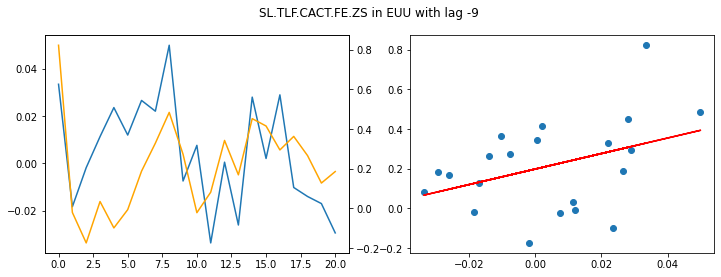

{'correlation': False, 'linear_regression': {'slope': 3.916992358620174, 'intercept': 0.1975807989236626, 'p_value': 0.08134981624829275, 'std_err': 2.128081754455564}, 'pearson_product_moment_correlation': {'r_value': 0.38900740580098414}, 'lag': -9}


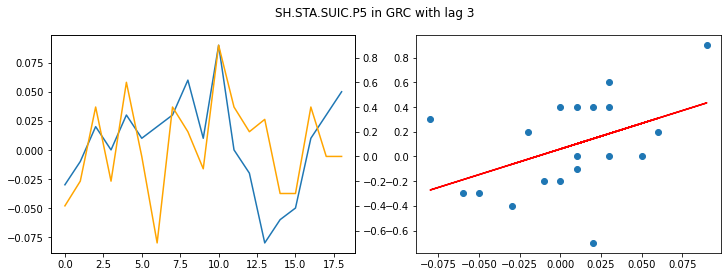

{'correlation': False, 'linear_regression': {'slope': 4.149831649831654, 'intercept': 0.060185185185185175, 'p_value': 0.05860522384706543, 'std_err': 2.0469500371676936}, 'pearson_product_moment_correlation': {'r_value': 0.44124385162577096}, 'lag': 3}


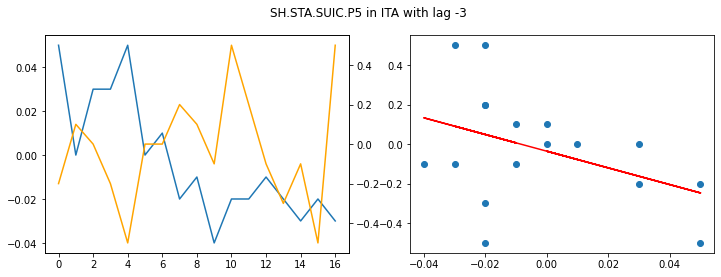

{'correlation': False, 'linear_regression': {'slope': -4.223809523809516, 'intercept': -0.03595238095238096, 'p_value': 0.0992120753938482, 'std_err': 2.4032703216348965}, 'pearson_product_moment_correlation': {'r_value': -0.4132336324492404}, 'lag': -3}


In [6]:
for region_id in regions:
    # Diff all series
    tfr[region_id]['differenced'] = {
            1: tfr[region_id]['data'].diff().iloc[1:]
        }
    for dataset_id in datasets:
        if region_id in datasets[dataset_id]:
            datasets[dataset_id][region_id]['differenced'] = {
                1: datasets[dataset_id][region_id]['data'].diff().iloc[1:]
            }
            # Try linear regression with lagging
            if datasets[dataset_id][region_id]['stationarity']['adfuller']['stationary']:
                linear_regression_lagged(
                    dataset_id, region_id,
                    tfr[region_id]['differenced'][1],
                    datasets[dataset_id][region_id]['differenced'][1],
                    10, output='always')

Nyní jsou tvrzení o korelaci mnohem skeptičtější a získané výsledky by tak mohly být smysluplnější.

## Korelace nestacionárních časových řad
Stejný postup vyzkoušíme i na nestacionárních časových řadách.
Diferenciaci potřebujeme pro kompenzaci nestacionarity, opět chceme porovnávat změny v trendu a ne pouze jeho celkové směřování.

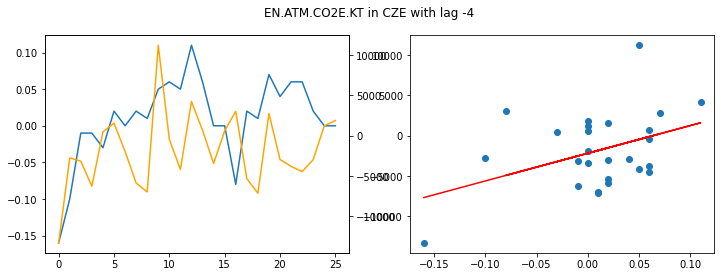

{'correlation': True, 'linear_regression': {'slope': 34346.31452581032, 'intercept': -2177.4424969987995, 'p_value': 0.03792421854245317, 'std_err': 15634.023341213648}, 'pearson_product_moment_correlation': {'r_value': 0.4091801547716043}, 'lag': -4}


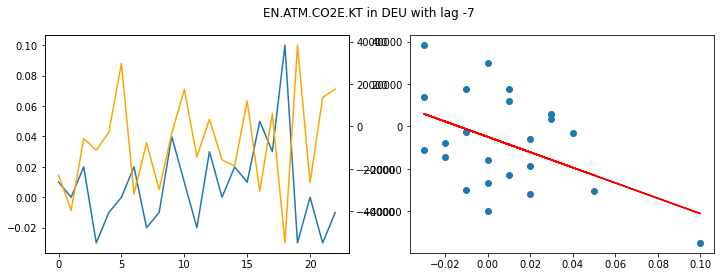

{'correlation': True, 'linear_regression': {'slope': -362197.4956063278, 'intercept': -4890.628295254827, 'p_value': 0.022921295861290877, 'std_err': 147569.72456845065}, 'pearson_product_moment_correlation': {'r_value': -0.472141407992325}, 'lag': -7}


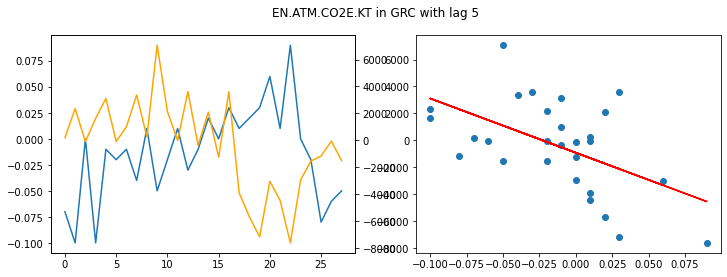

{'correlation': True, 'linear_regression': {'slope': -40284.01496925956, 'intercept': -915.6402031542367, 'p_value': 0.004044316132402184, 'std_err': 12775.385884067111}, 'pearson_product_moment_correlation': {'r_value': -0.5259585987897405}, 'lag': 5}


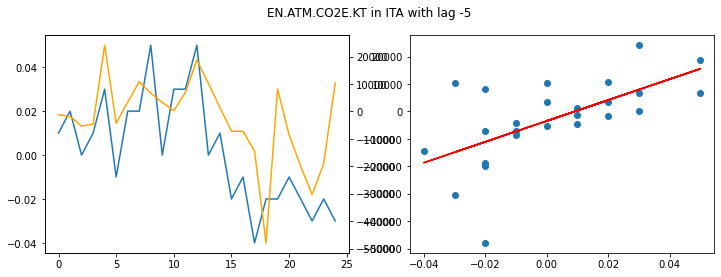

{'correlation': True, 'linear_regression': {'slope': 380891.8918918914, 'intercept': -3457.7837837837833, 'p_value': 0.0010931950677765658, 'std_err': 102075.2387627359}, 'pearson_product_moment_correlation': {'r_value': 0.6140831914908443}, 'lag': -5}


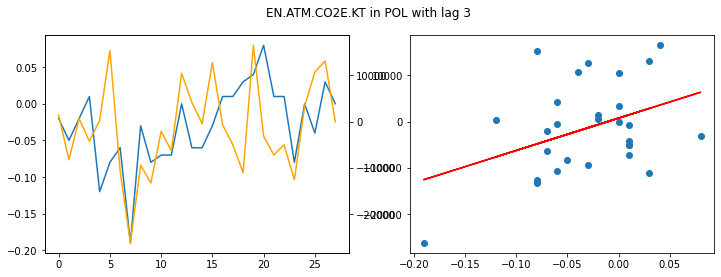

{'correlation': True, 'linear_regression': {'slope': 69968.99157849285, 'intercept': 735.5093932196089, 'p_value': 0.03911819958999922, 'std_err': 32206.212245423074}, 'pearson_product_moment_correlation': {'r_value': 0.3919729811810651}, 'lag': 3}


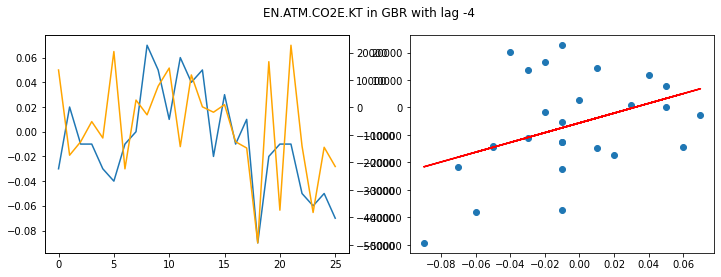

{'correlation': True, 'linear_regression': {'slope': 177693.2571849668, 'intercept': -5608.277450257922, 'p_value': 0.04563324771673765, 'std_err': 84283.29617980031}, 'pearson_product_moment_correlation': {'r_value': 0.39530060104615283}, 'lag': -4}


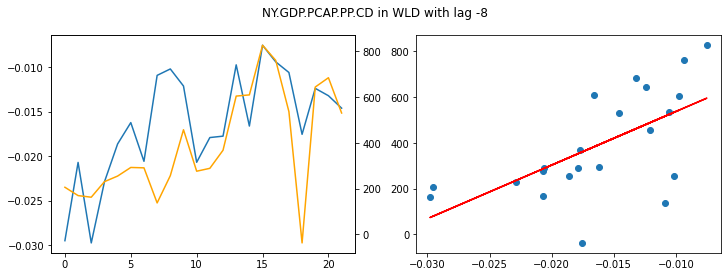

{'correlation': True, 'linear_regression': {'slope': 23435.195282251032, 'intercept': 771.6128799901971, 'p_value': 0.001935071755141073, 'std_err': 6571.780580030355}, 'pearson_product_moment_correlation': {'r_value': 0.6234497189248394}, 'lag': -8}


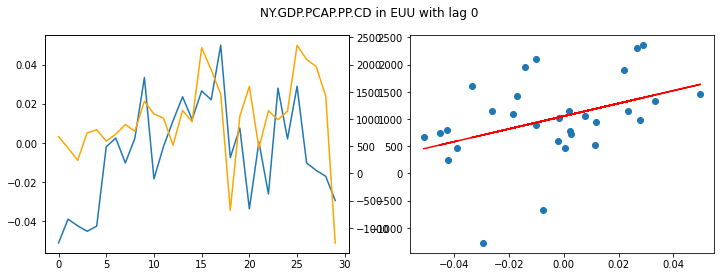

{'correlation': True, 'linear_regression': {'slope': 11740.005862644917, 'intercept': 1053.7420650655695, 'p_value': 0.02840372973256, 'std_err': 5079.754629243405}, 'pearson_product_moment_correlation': {'r_value': 0.4002524316087709}, 'lag': 0}


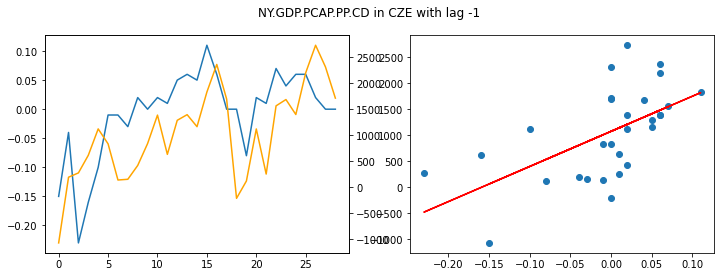

{'correlation': True, 'linear_regression': {'slope': 6748.995671592402, 'intercept': 1073.8408352718504, 'p_value': 0.0009237092646393063, 'std_err': 1814.2285834123988}, 'pearson_product_moment_correlation': {'r_value': 0.5821184448944862}, 'lag': -1}


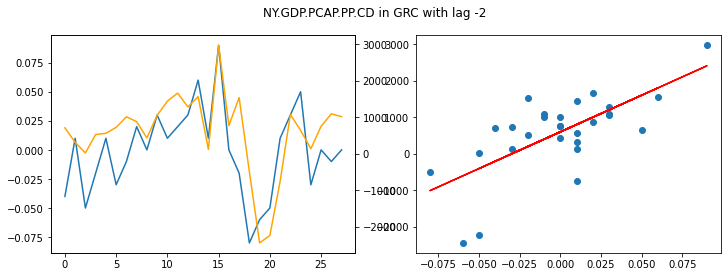

{'correlation': True, 'linear_regression': {'slope': 20110.155789941775, 'intercept': 596.9741679891335, 'p_value': 5.370391865248474e-05, 'std_err': 4170.151669479117}, 'pearson_product_moment_correlation': {'r_value': 0.6871251855294861}, 'lag': -2}


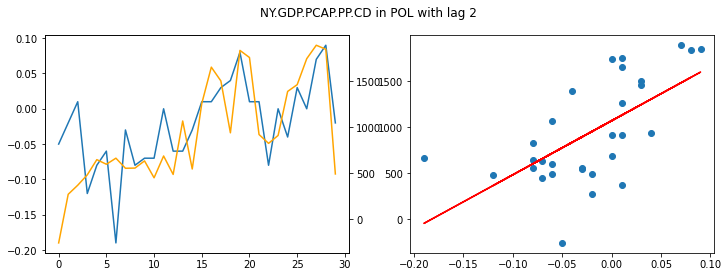

{'correlation': True, 'linear_regression': {'slope': 5876.168971095831, 'intercept': 1068.070883946871, 'p_value': 0.00020485363436882766, 'std_err': 1377.2666393644083}, 'pearson_product_moment_correlation': {'r_value': 0.6276814343974181}, 'lag': 2}


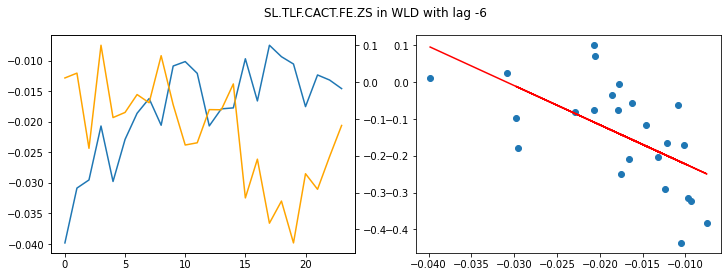

{'correlation': True, 'linear_regression': {'slope': -10.674303580970413, 'intercept': -0.32931272947786216, 'p_value': 0.0018774187451316587, 'std_err': 3.0227401944142196}, 'pearson_product_moment_correlation': {'r_value': -0.6014729447555806}, 'lag': -6}


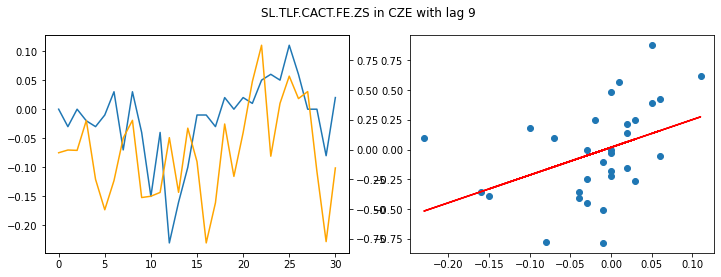

{'correlation': True, 'linear_regression': {'slope': 2.333520090033069, 'intercept': 0.018562447303634957, 'p_value': 0.0225532989104153, 'std_err': 0.9685095677496898}, 'pearson_product_moment_correlation': {'r_value': 0.4083999900612312}, 'lag': 9}


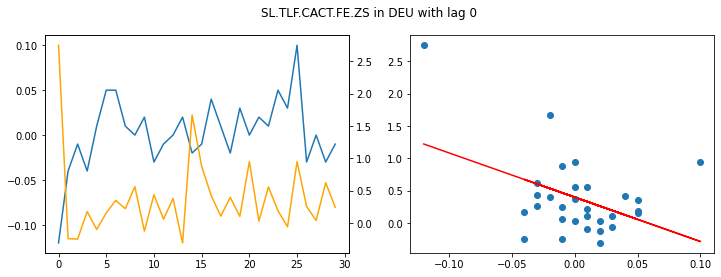

{'correlation': True, 'linear_regression': {'slope': -6.837461171864824, 'intercept': 0.4010998984928131, 'p_value': 0.016540734099225636, 'std_err': 2.6816294042842124}, 'pearson_product_moment_correlation': {'r_value': -0.4340893551103392}, 'lag': 0}


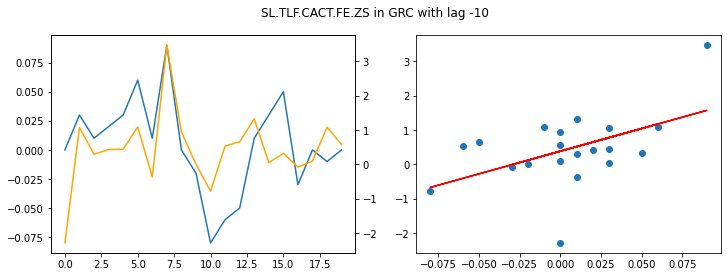

{'correlation': True, 'linear_regression': {'slope': 13.1969920537311, 'intercept': 0.3841634548866251, 'p_value': 0.02539457645005001, 'std_err': 5.41433517433789}, 'pearson_product_moment_correlation': {'r_value': 0.49814831340415705}, 'lag': -10}


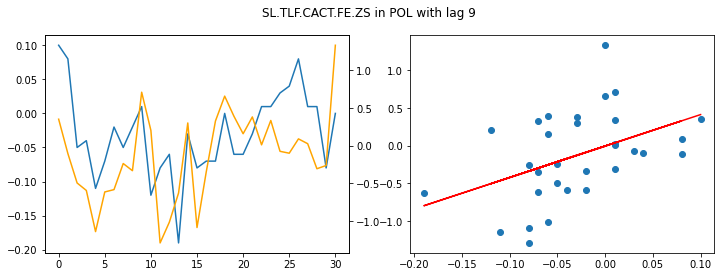

{'correlation': True, 'linear_regression': {'slope': 4.169614987331931, 'intercept': -0.003762892245923799, 'p_value': 0.013212934558126312, 'std_err': 1.5795113233013869}, 'pearson_product_moment_correlation': {'r_value': 0.4401607960442985}, 'lag': 9}


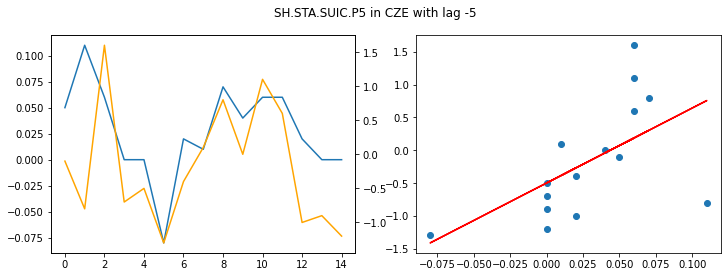

{'correlation': True, 'linear_regression': {'slope': 11.428571428571436, 'intercept': -0.5000000000000002, 'p_value': 0.02447623232851524, 'std_err': 4.492649300236791}, 'pearson_product_moment_correlation': {'r_value': 0.5764930300097757}, 'lag': -5}


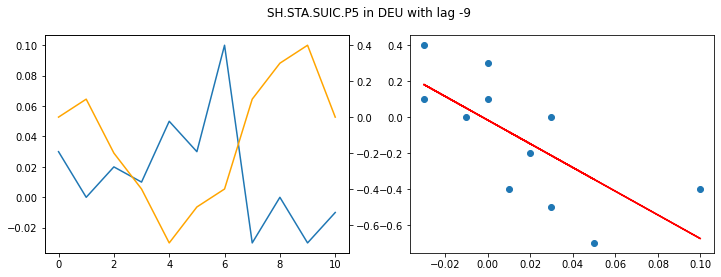

{'correlation': True, 'linear_regression': {'slope': -6.602067183462528, 'intercept': -0.016149870801033778, 'p_value': 0.014343645740450757, 'std_err': 2.181916014072105}, 'pearson_product_moment_correlation': {'r_value': -0.7101291836779522}, 'lag': -9}


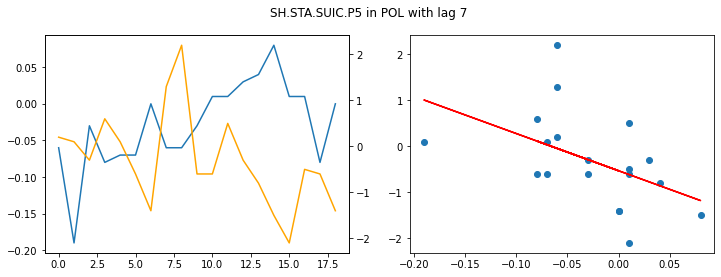

{'correlation': True, 'linear_regression': {'slope': -8.106952734311994, 'intercept': -0.530408130343604, 'p_value': 0.03733910176908432, 'std_err': 3.589337080136751}, 'pearson_product_moment_correlation': {'r_value': -0.4804340742509301}, 'lag': 7}


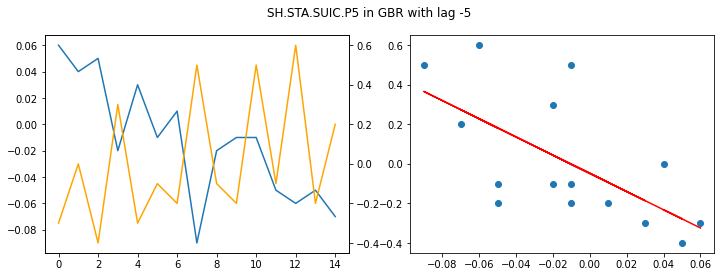

{'correlation': True, 'linear_regression': {'slope': -4.605568445475638, 'intercept': -0.04807424593967508, 'p_value': 0.00982417916024969, 'std_err': 1.5242665958798596}, 'pearson_product_moment_correlation': {'r_value': -0.6422986334164805}, 'lag': -5}


In [7]:
for dataset_id in datasets:
    for region_id in datasets[dataset_id]:
        datasets[dataset_id][region_id]['differenced'] = {
            1: datasets[dataset_id][region_id]['data'].diff().iloc[1:]
        }
        if not datasets[dataset_id][region_id]['stationarity']['adfuller']['stationary']:
            # Try linear regression with lagging
            linear_regression_lagged(
                dataset_id, region_id,
                tfr[region_id]['differenced'][1],
                datasets[dataset_id][region_id]['differenced'][1],
                10, output='corr')

Výsledky ověříme ještě pohledem na původní nediferencovaná data.
Je třeba brát v úvahu případný lag, při kterém byla korelace nalezena, grafy níže totiž ukazují časové řady bez lagu.

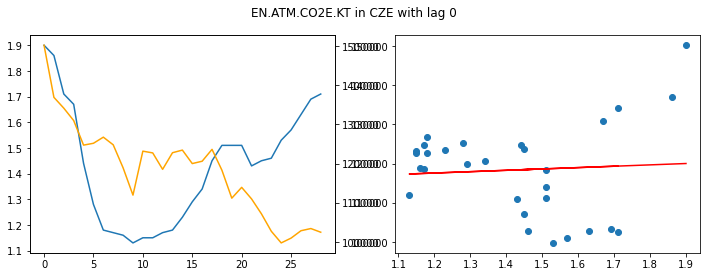

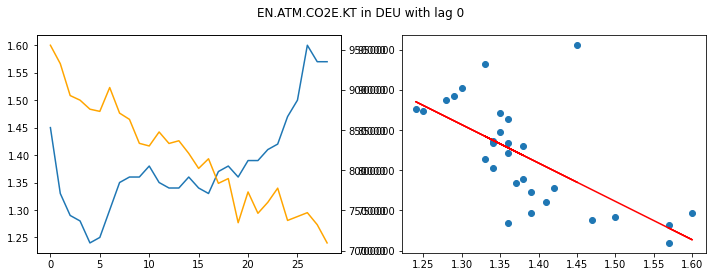

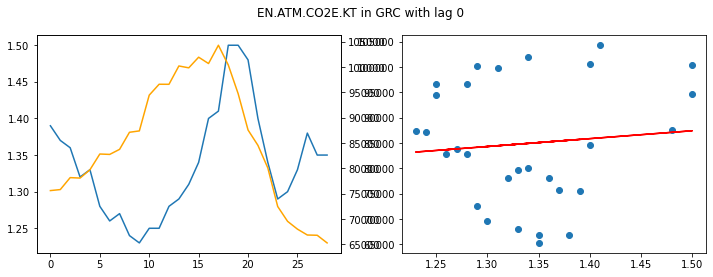

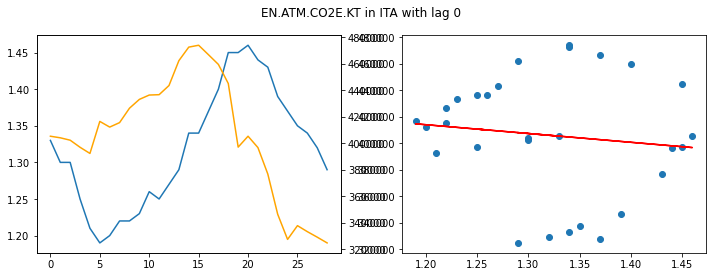

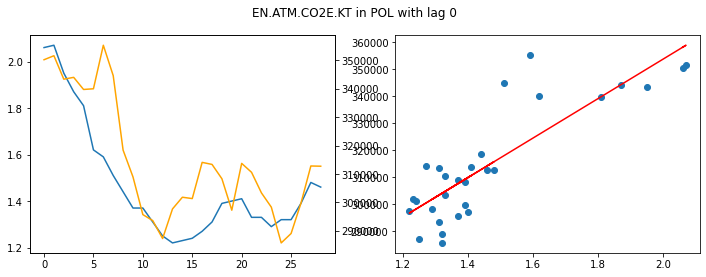

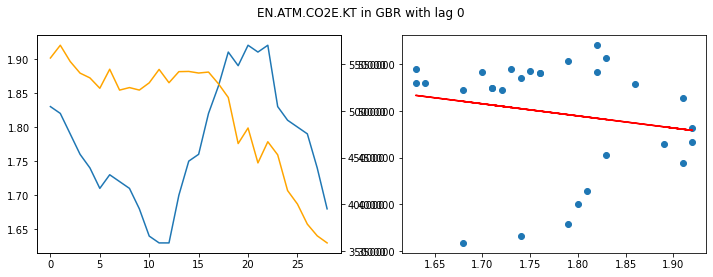

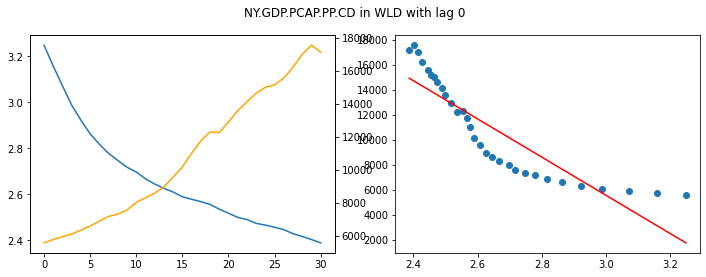

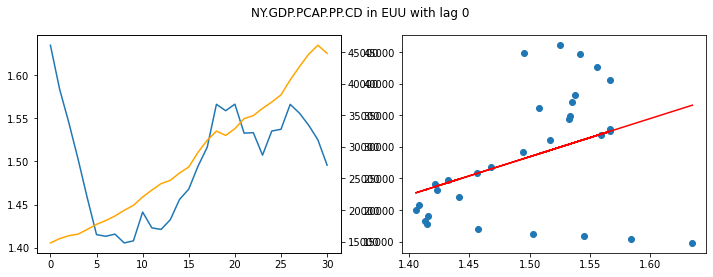

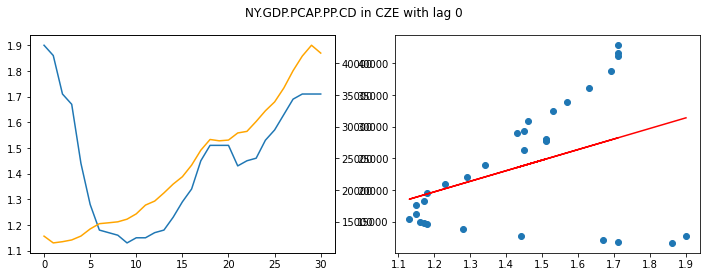

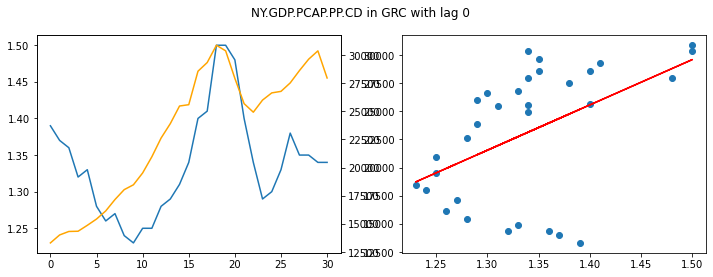

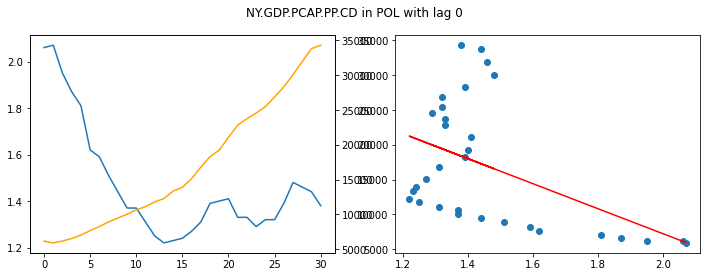

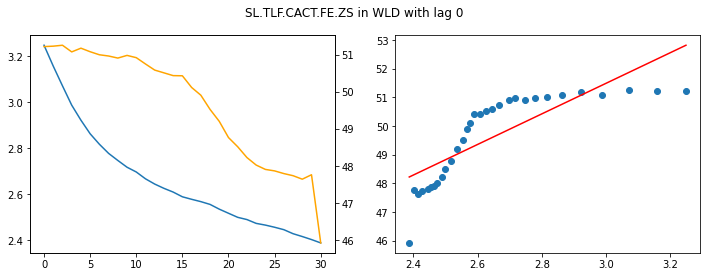

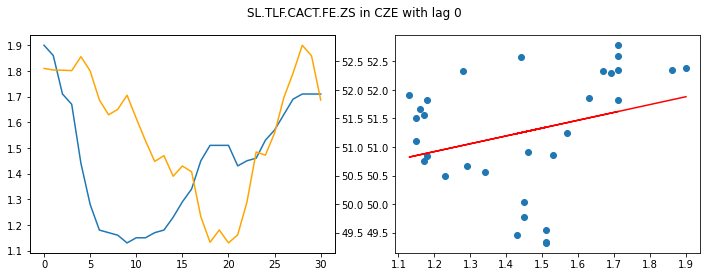

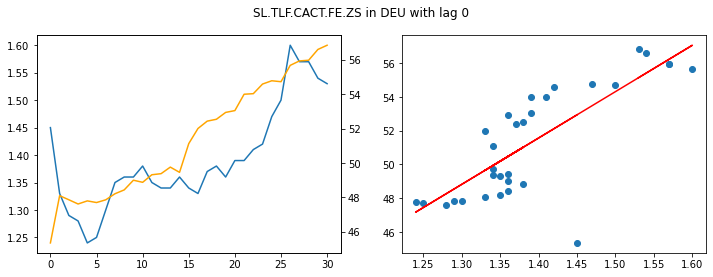

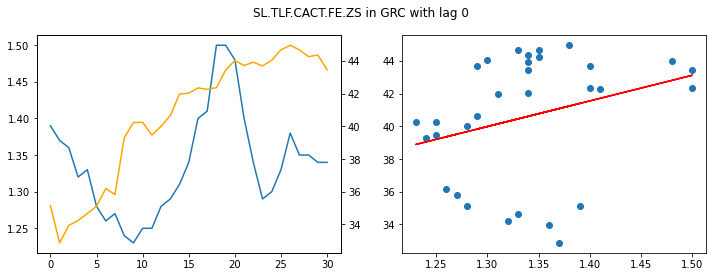

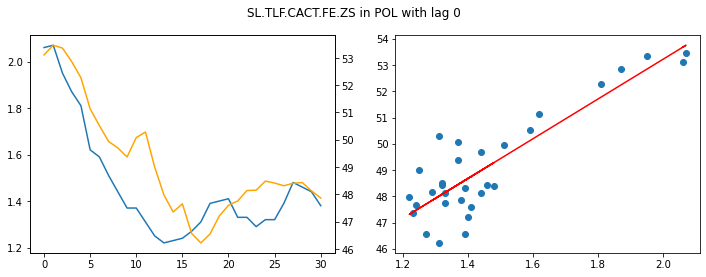

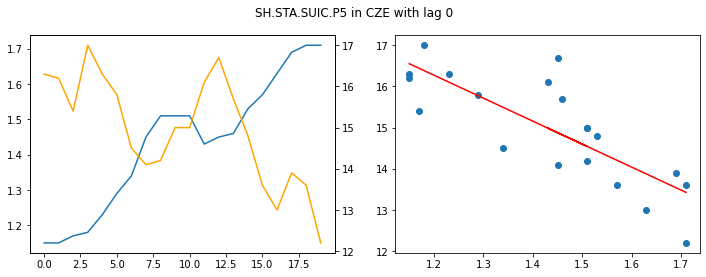

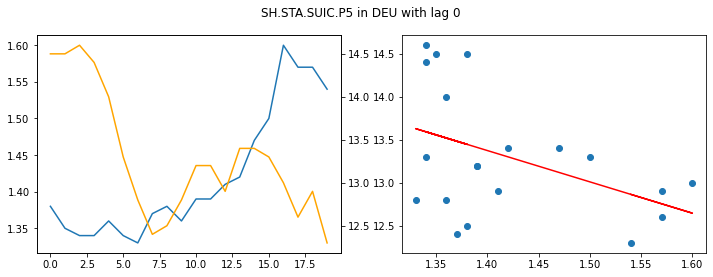

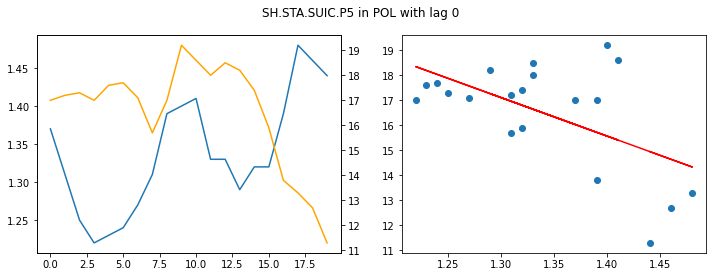

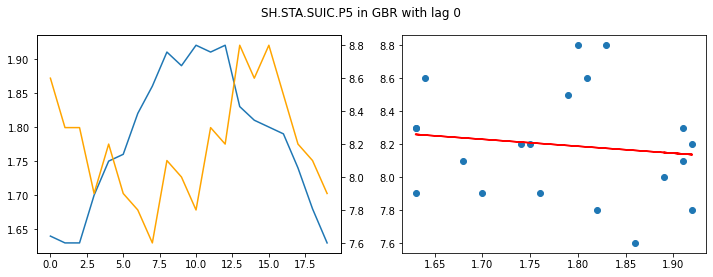

In [8]:
for dataset_id in datasets:
    for region_id in datasets[dataset_id]:
        if not datasets[dataset_id][region_id]['stationarity']['adfuller']['stationary'] \
            and datasets[dataset_id][region_id]['relation']['correlation']:

            
            primary = tfr[region_id]['data']
            primary.index = primary.index.astype(int)
            other = datasets[dataset_id][region_id]['data']
            other.index = other.index.astype(int)

            join = pd.merge(
                primary,
                other,
                on='Year',
                how='inner')

            X = join['SP.DYN.TFRT.IN']
            y = join[dataset_id]

            plot_linear_regression(dataset_id, region_id, X, y, 0)

Je patrné, že změny v trendu se u všech dvojic skutečně do určité míry v závislosti na korelačním koeficientu podobají (pokud bereme v úvahu zpoždění, při kterém byla korelace nalezena).